# Interpolation of PM2.5 Levels

This notebook performs interpolation of PM2.5 air quality data using different feature sets. The goal is to estimate PM2.5 concentrations at unmonitored locations using observed data from fixed stations.

## Objective

- Perform interpolation to estimate PM2.5 levels in unmeasured locations.
- Use features sets as: spatial, spatial + temporal and spatial + temporal + meteorological.
- Visualize the interpolated air pollution surface across Delhi.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabpfn import TabPFNRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import warnings
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore")

In [ ]:
# --- Safe scaler ---
def safe_standard_scaler(train_df, test_df, columns):
    train_scaled = train_df.copy()
    test_scaled = test_df.copy()
    for col in columns:
        mean = train_df[col].mean()
        std = train_df[col].std()
        if std == 0 or np.isnan(std):
            std = 1.0
        train_scaled[col] = (train_df[col] - mean) / std
        test_scaled[col] = (test_df[col] - mean) / std
    return train_scaled, test_scaled

## Dataset Description
- **Format**: CSV
- **Columns**:
  - `Timestamp`: Date and time of observation.
  - `Latitude`, `Longitude`: Location of monitoring station.
  - `PM2.5`: Particulate matter concentration (µg/m³).
  - Additional columns: [e.g., Temperature, Humidity, etc.]
- **Time Range**: January 2023 to December 2023
- **Spatial Scope**: Multiple stations across Delhi

## Load and Inspect the Dataset
### Clean and Preprocess the Data

- Convert timestamps
- Handle missing values
- Encode date/time features

In [ ]:
# --- Load Dataset ---
df = pd.read_csv("merged_exact_on_lat_long.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values("Timestamp")
df = df[df['Timestamp'].dt.month == 1].copy()

# --- Feature Engineering ---
df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['month'] = df['Timestamp'].dt.month
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)


# Define station by lat-lon pair
df['station'] = df['latitude'].astype(str) + "_" + df['longitude'].astype(str)

# --- Unique Stations ---
stations = df['station'].unique()

### Models

In [ ]:
# --- Models Dictionary ---
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "CatBoost": CatBoostRegressor(iterations=100, verbose=0, random_state=42),
    "TabNet": TabNetRegressor(seed=42, verbose=0),
    "TabPFN": TabPFNRegressor(device='cpu', ignore_pretraining_limits=True)
}

### Feature Definition

In [ ]:
# --- Feature and Target ---
meteorological_features = ['AT', 'TOT-RF', 'BP', 'RF', 'WD', 'RH', 'WS', 'SR']
temporal_features = ['hour_sin', 'hour_cos', 'day', 'month']
geo_features = ['latitude', 'longitude', 'average_road_density', 'population_density']
feature_cols = geo_features+temporal_features
target = 'PM2.5'
df = df.dropna(subset=[target])

## Input Features = Spatial Features + Temporal Features


=== Leave-Out Station: 28.647622_77.315809 ===
RandomForest | MAE: 44.79 | RMSE: 73.85 | R2: 0.66
XGBoost | MAE: 44.38 | RMSE: 72.47 | R2: 0.67
CatBoost | MAE: 44.07 | RMSE: 71.02 | R2: 0.68

Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_rmse = 0.8594
TabNet | MAE: 63.82 | RMSE: 89.05 | R2: 0.50
TabPFN | MAE: 45.90 | RMSE: 73.34 | R2: 0.66

=== Leave-Out Station: 28.498571_77.26484 ===
RandomForest | MAE: 23.28 | RMSE: 36.79 | R2: 0.88
XGBoost | MAE: 25.12 | RMSE: 36.54 | R2: 0.88
CatBoost | MAE: 30.59 | RMSE: 41.53 | R2: 0.85
Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_val_0_rmse = 0.60277
TabNet | MAE: 46.77 | RMSE: 63.25 | R2: 0.65
TabPFN | MAE: 24.36 | RMSE: 38.84 | R2: 0.87

=== Leave-Out Station: 28.623763_77.287209 ===
RandomForest | MAE: 23.47 | RMSE: 34.20 | R2: 0.91
XGBoost | MAE: 23.82 | RMSE: 33.74 | R2: 0.91
CatBoost | MAE: 26.96 | RMSE: 38.12 | R2: 0.89
Stop training because you reached max_epochs = 100 with 

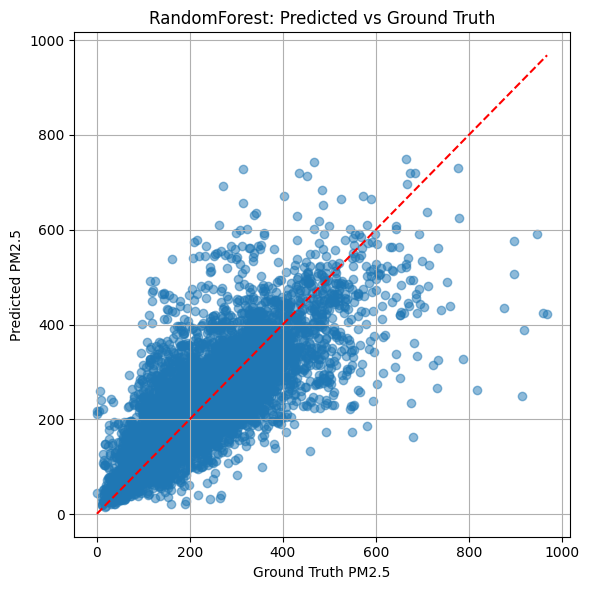

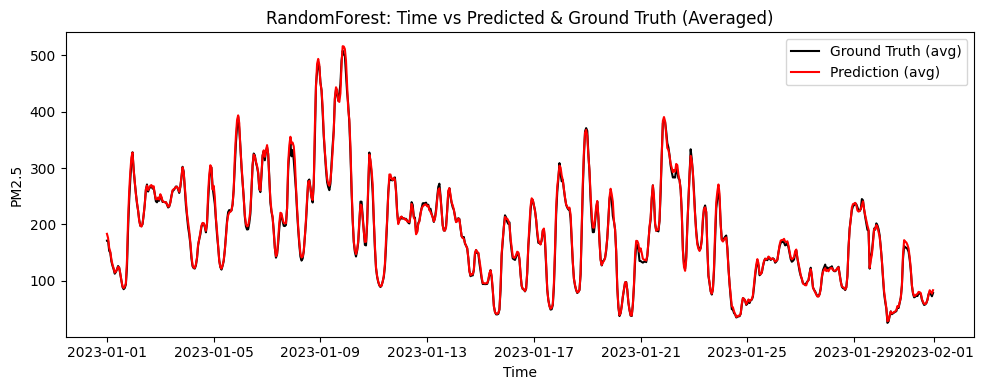

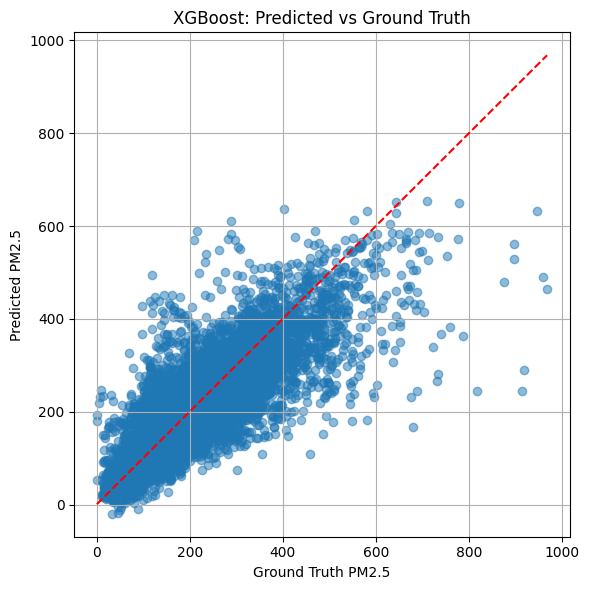

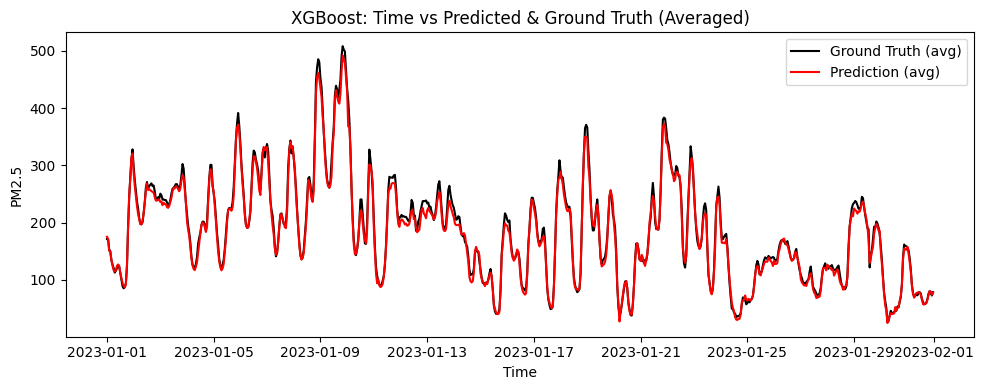

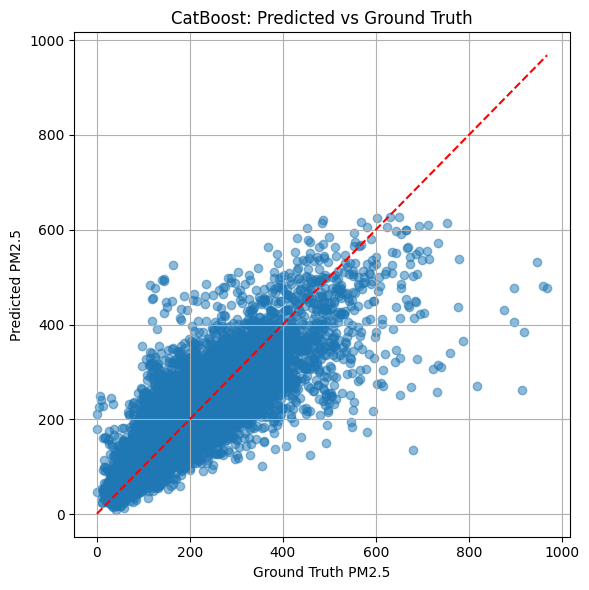

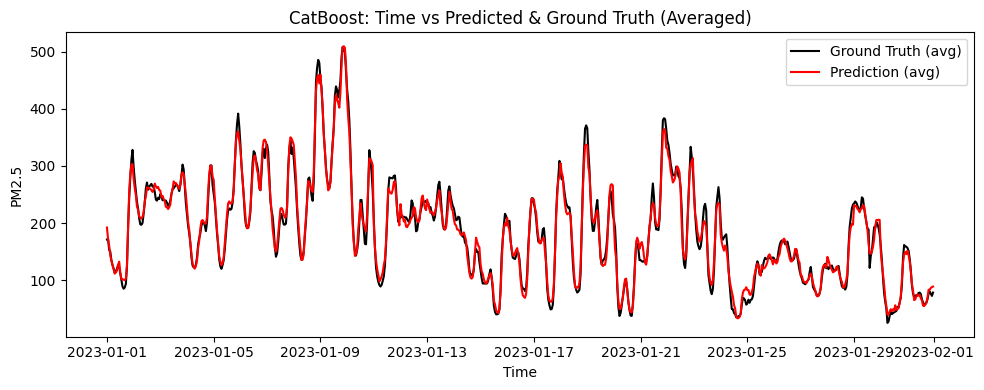

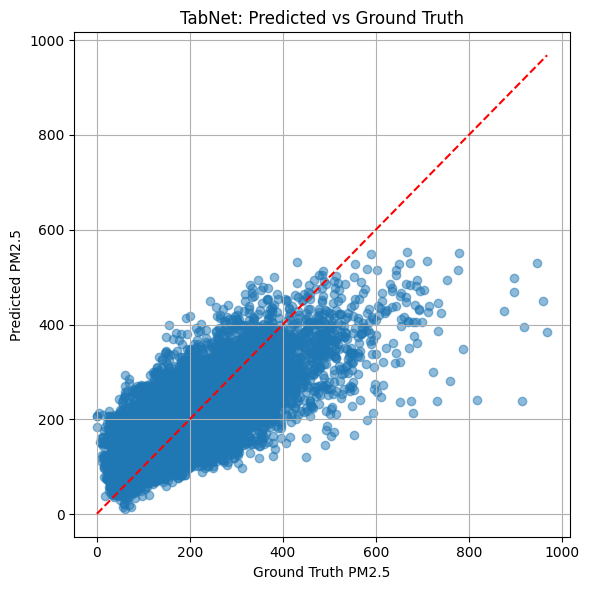

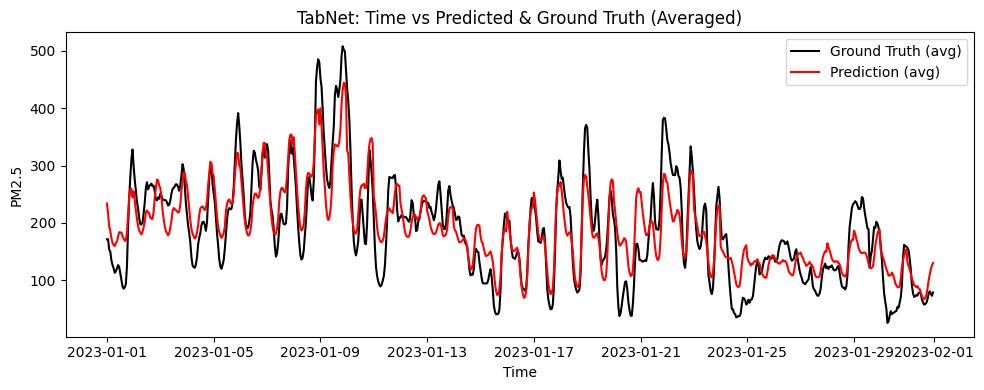

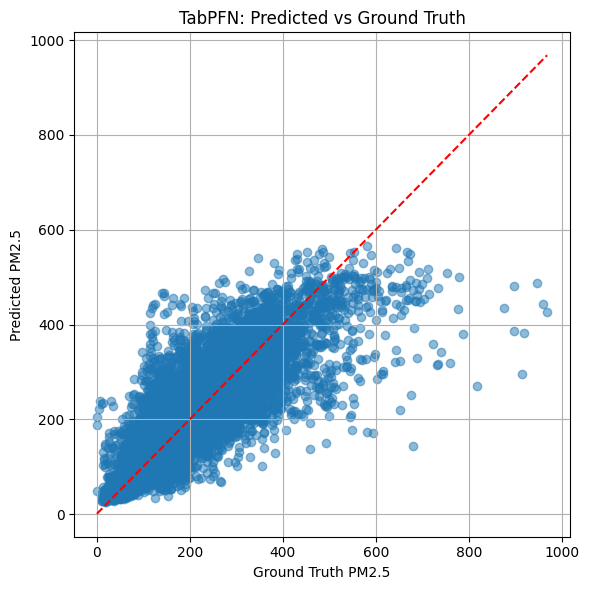

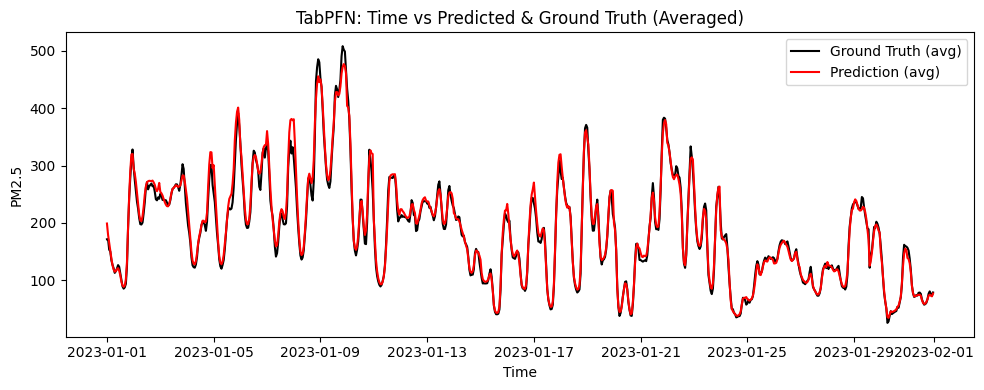

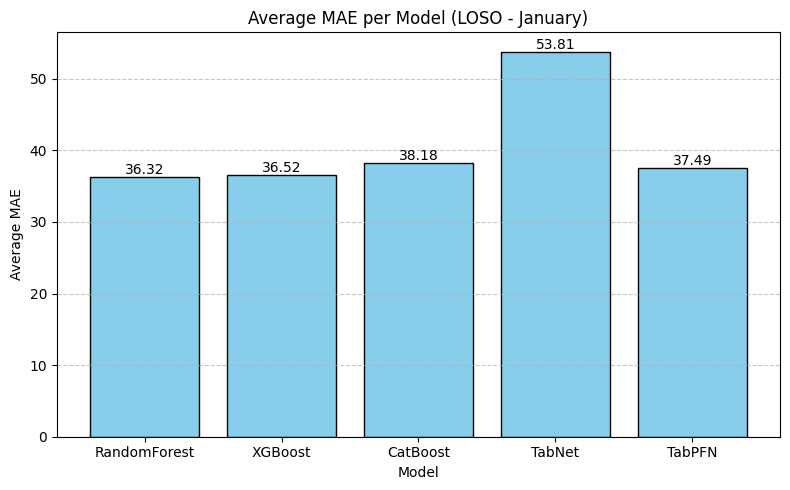

In [ ]:
# --- Metrics Storage ---
results = {
    name: {
        "MAE": [], "RMSE": [], "R2": [],
        "Preds": [], "GT": [], "Time": []
    } for name in models
}

# --- LOSO Loop ---
for station in stations:
    print(f"\n=== Leave-Out Station: {station} ===")
    test_df = df[df['station'] == station]
    train_df = df[df['station'] != station]

    # Drop NA rows
    train_df = train_df.dropna(subset=feature_cols + [target])
    test_df = test_df.dropna(subset=feature_cols + [target])
    if len(train_df) == 0 or len(test_df) == 0:
        print(f"Skipping station {station} due to empty train/test after dropping NA")
        continue

    # Feature Scaling
    X_train_df, X_test_df = safe_standard_scaler(train_df[feature_cols], test_df[feature_cols], feature_cols)
    y_train_vals = train_df[[target]]
    y_test_vals = test_df[[target]]

    # Target scaling
    y_mean = y_train_vals.mean().values[0]
    y_std = y_train_vals.std().values[0]
    if y_std == 0 or np.isnan(y_std):
        y_std = 1.0
    y_train_scaled = (y_train_vals - y_mean) / y_std
    y_test_scaled = (y_test_vals - y_mean) / y_std

    X_train = X_train_df.values
    X_test = X_test_df.values
    y_train = y_train_scaled.values.ravel()
    y_test = y_test_scaled.values.ravel()
    y_train_2d = y_train.reshape(-1, 1)
    y_test_2d = y_test.reshape(-1, 1)

    for name, model in models.items():
        if name == "TabNet":
            model.fit(
                X_train, y_train_2d,
                eval_set=[(X_test, y_test_2d)],
                eval_metric=['rmse'],
                max_epochs=100,
                patience=20,
                batch_size=1024,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False
            )
            y_pred = model.predict(X_test).squeeze()
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Denormalize predictions
        y_pred_denorm = y_pred * y_std + y_mean
        y_test_denorm = y_test * y_std + y_mean

        # Metrics
        mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
        rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
        r2 = r2_score(y_test_denorm, y_pred_denorm)

        results[name]["MAE"].append(mae)
        results[name]["RMSE"].append(rmse)
        results[name]["R2"].append(r2)

        print(f"{name} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.2f}")

        # Store predictions and ground truth for plotting
        results[name]["Preds"].extend(y_pred_denorm)
        results[name]["GT"].extend(y_test_denorm)
        results[name]["Time"].extend(test_df['Timestamp'].values)

# --- Summary ---
print("\n\n=== Overall LOSO Results ===")
for name in results:
    mae_mean = np.mean(results[name]["MAE"])
    rmse_mean = np.mean(results[name]["RMSE"])
    r2_mean = np.mean(results[name]["R2"])
    print(f"{name:10s} | MAE: {mae_mean:.2f} | RMSE: {rmse_mean:.2f} | R2: {r2_mean:.2f}")

# --- Plots ---
os.makedirs("loso_plots", exist_ok=True)
for name in results:
    preds = np.array(results[name]["Preds"])
    gt = np.array(results[name]["GT"])
    time = pd.to_datetime(results[name]["Time"])

    # Scatter Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(gt, preds, alpha=0.5)
    plt.plot([gt.min(), gt.max()], [gt.min(), gt.max()], 'r--')
    plt.xlabel("Ground Truth PM2.5")
    plt.ylabel("Predicted PM2.5")
    plt.title(f"{name}: Predicted vs Ground Truth")
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"loso_plots/{name}_scatter.png")
    plt.show()

    # Line Plot over Time (averaged)
    df_plot = pd.DataFrame({
        'time': time,
        'ground_truth': gt,
        'prediction': preds
    })
    df_mean = df_plot.groupby('time').mean().reset_index()

    plt.figure(figsize=(10, 4))
    plt.plot(df_mean['time'], df_mean['ground_truth'], label="Ground Truth (avg)", color='black')
    plt.plot(df_mean['time'], df_mean['prediction'], label="Prediction (avg)", color='red')
    plt.xlabel("Time")
    plt.ylabel("PM2.5")
    plt.title(f"{name}: Time vs Predicted & Ground Truth (Averaged)")
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"loso_plots/{name}_time_avg.png")
    plt.show()

# --- Bar Plot of Average MAE per Model ---
model_names = []
mae_means = []
rmse_mean = []
r2_mean = []

for name in results:
    model_names.append(name)
    mae_means.append(np.mean(results[name]["MAE"]))

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, mae_means, color='skyblue', edgecolor='black')
plt.ylabel("Average MAE")
plt.xlabel("Model")
plt.title("Average MAE per Model (LOSO - January)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.2f}", ha='center', va='bottom')

plt.tight_layout()
# plt.savefig("loso_plots/average_mae_barplot.png")
plt.show()

## Input Features = Spatial Features + Temporal Features + Meteorological Features

In [ ]:
# --- Feature and Target ---
meteorological_features = ['AT', 'TOT-RF', 'BP', 'RF', 'WD', 'RH', 'WS', 'SR']
temporal_features = ['hour_sin', 'hour_cos', 'day', 'month']
geo_features = ['latitude', 'longitude', 'average_road_density', 'population_density']
feature_cols = geo_features+temporal_features+meteorological_features
target = 'PM2.5'
df = df.dropna(subset=[target])


=== Leave-Out Station: 28.647622_77.315809 ===
RandomForest | MAE: 46.88 | RMSE: 75.78 | R2: 0.64
XGBoost | MAE: 46.89 | RMSE: 75.65 | R2: 0.64
CatBoost | MAE: 49.52 | RMSE: 74.35 | R2: 0.65

Early stopping occurred at epoch 77 with best_epoch = 57 and best_val_0_rmse = 0.72716
TabNet | MAE: 53.88 | RMSE: 75.35 | R2: 0.64
TabPFN | MAE: 46.24 | RMSE: 74.31 | R2: 0.65

=== Leave-Out Station: 28.498571_77.26484 ===
RandomForest | MAE: 31.76 | RMSE: 48.55 | R2: 0.80
XGBoost | MAE: 40.92 | RMSE: 53.67 | R2: 0.75
CatBoost | MAE: 34.64 | RMSE: 48.70 | R2: 0.80

Early stopping occurred at epoch 87 with best_epoch = 67 and best_val_0_rmse = 0.6419
TabNet | MAE: 50.23 | RMSE: 67.36 | R2: 0.61
TabPFN | MAE: 27.61 | RMSE: 41.27 | R2: 0.85

=== Leave-Out Station: 28.623763_77.287209 ===
RandomForest | MAE: 31.43 | RMSE: 46.38 | R2: 0.83
XGBoost | MAE: 32.38 | RMSE: 44.40 | R2: 0.85
CatBoost | MAE: 30.57 | RMSE: 41.20 | R2: 0.87
Stop training because you reached max_epochs = 100 with best_epoch = 8

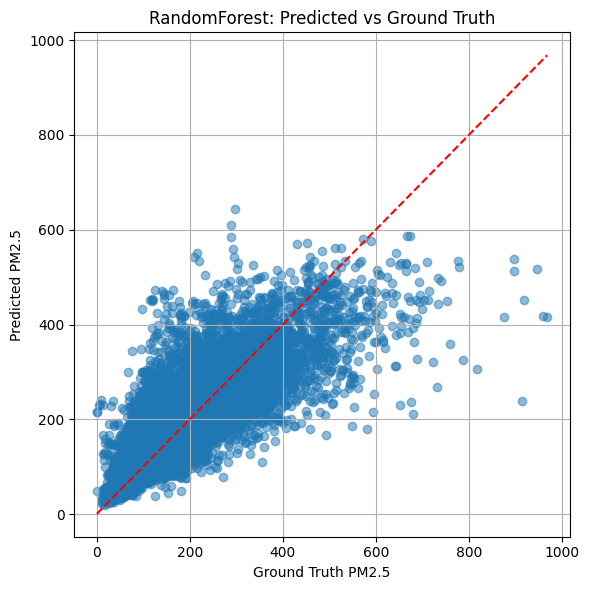

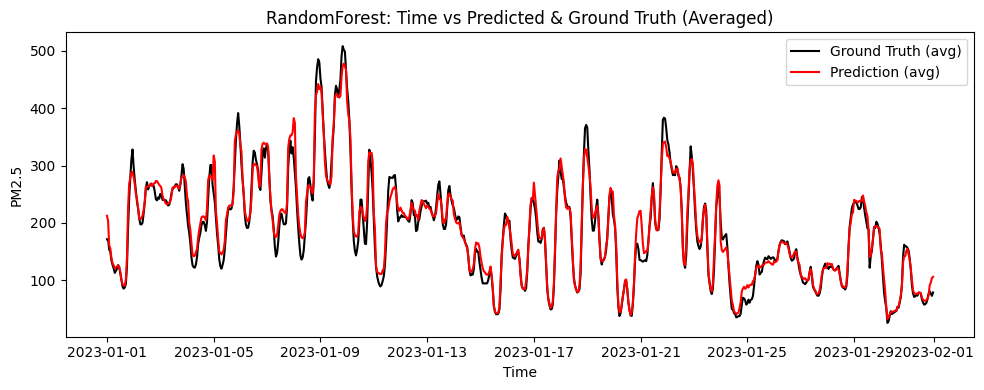

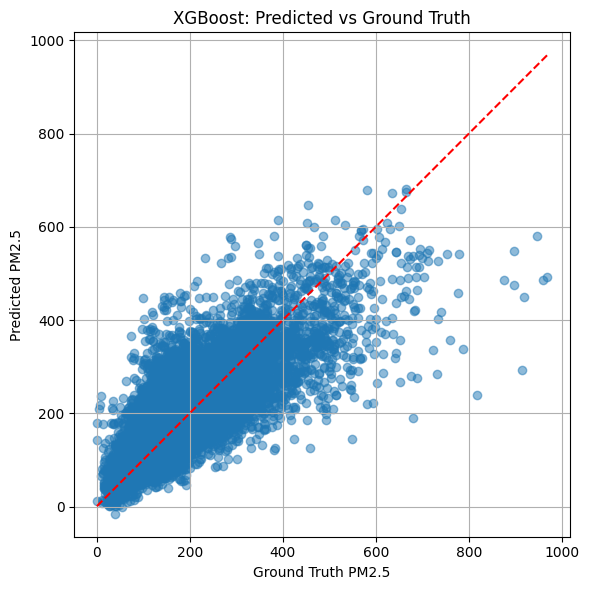

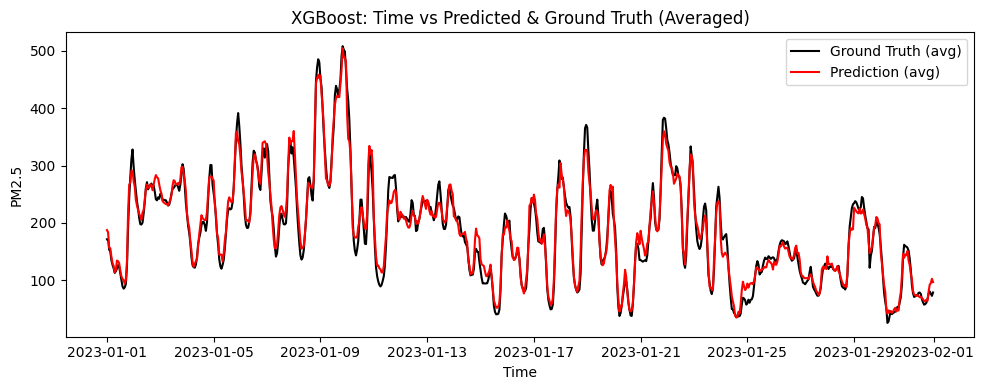

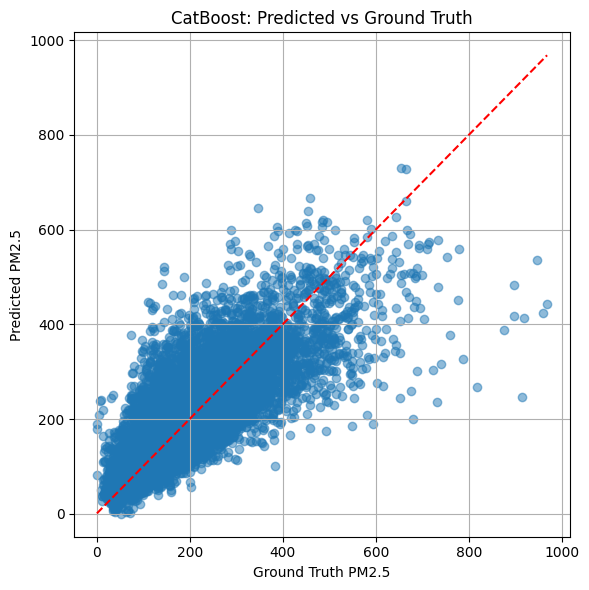

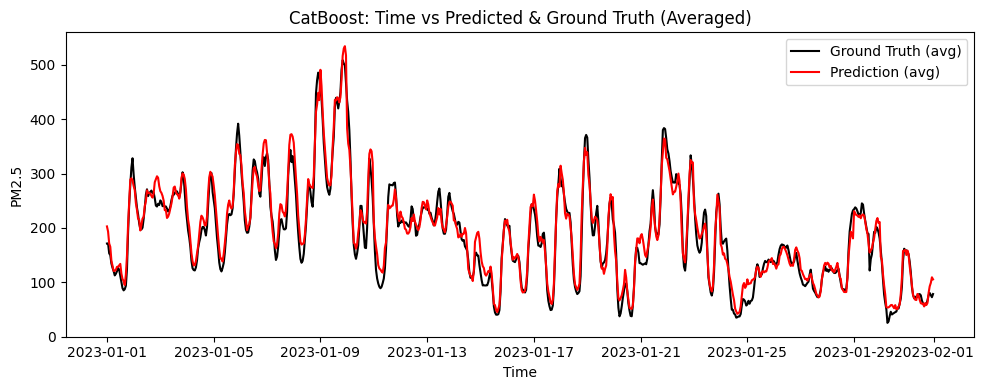

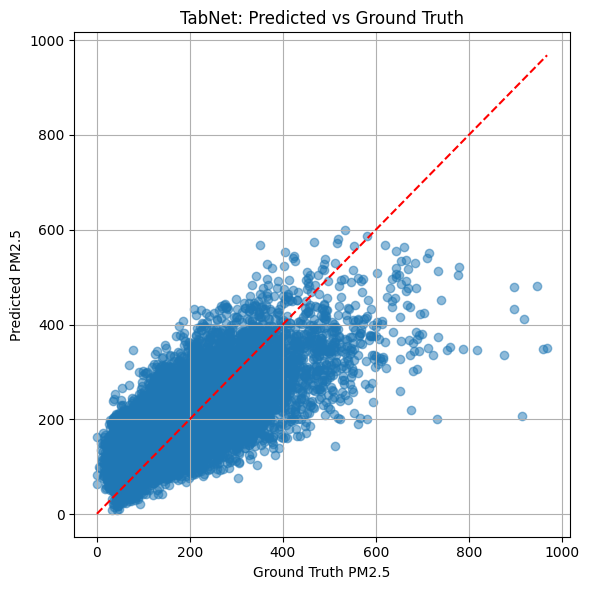

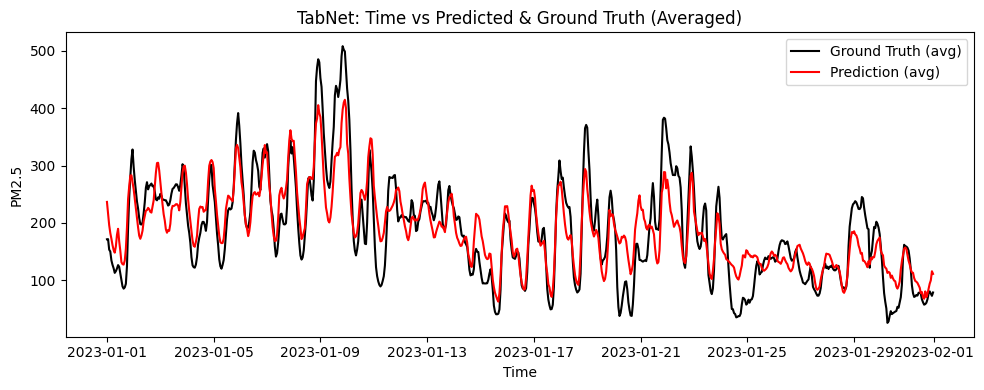

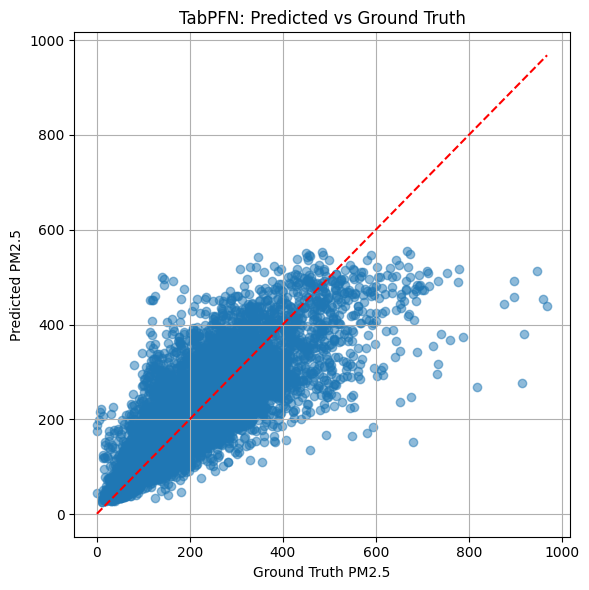

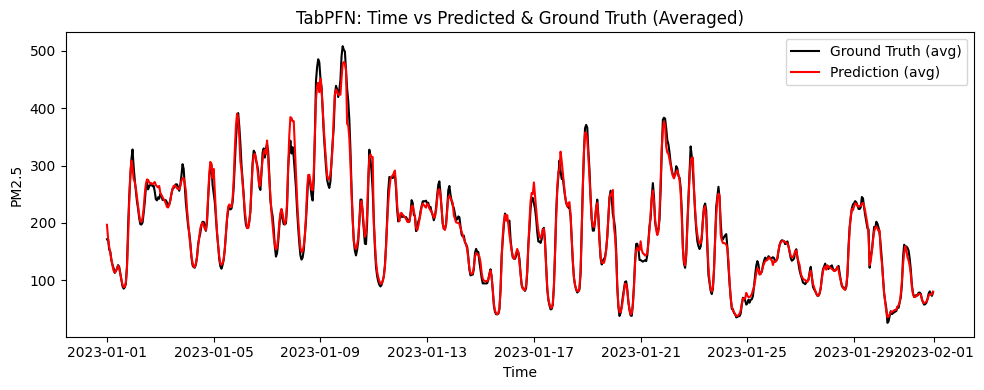

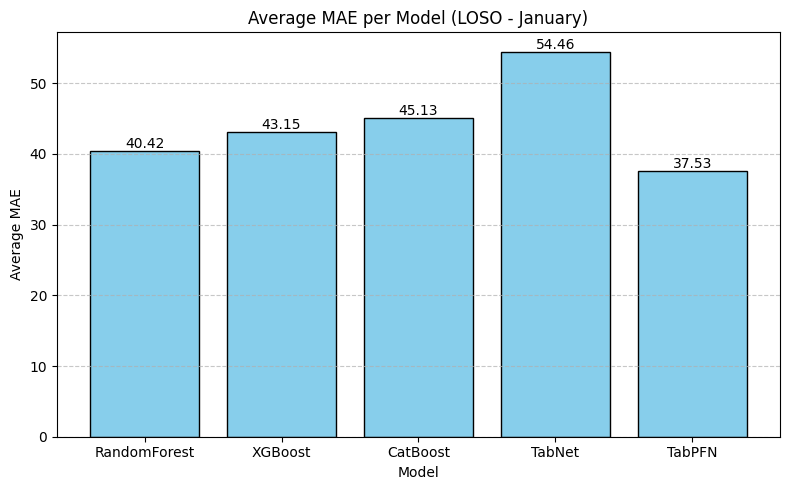

In [ ]:
# --- Metrics Storage ---
results = {
    name: {
        "MAE": [], "RMSE": [], "R2": [],
        "Preds": [], "GT": [], "Time": []
    } for name in models
}

# --- LOSO Loop ---
for station in stations:
    print(f"\n=== Leave-Out Station: {station} ===")
    test_df = df[df['station'] == station]
    train_df = df[df['station'] != station]

    # Drop NA rows
    train_df = train_df.dropna(subset=feature_cols + [target])
    test_df = test_df.dropna(subset=feature_cols + [target])
    if len(train_df) == 0 or len(test_df) == 0:
        print(f"Skipping station {station} due to empty train/test after dropping NA")
        continue

    # Feature Scaling
    X_train_df, X_test_df = safe_standard_scaler(train_df[feature_cols], test_df[feature_cols], feature_cols)
    y_train_vals = train_df[[target]]
    y_test_vals = test_df[[target]]

    # Target scaling
    y_mean = y_train_vals.mean().values[0]
    y_std = y_train_vals.std().values[0]
    if y_std == 0 or np.isnan(y_std):
        y_std = 1.0
    y_train_scaled = (y_train_vals - y_mean) / y_std
    y_test_scaled = (y_test_vals - y_mean) / y_std

    X_train = X_train_df.values
    X_test = X_test_df.values
    y_train = y_train_scaled.values.ravel()
    y_test = y_test_scaled.values.ravel()
    y_train_2d = y_train.reshape(-1, 1)
    y_test_2d = y_test.reshape(-1, 1)

    for name, model in models.items():
        if name == "TabNet":
            model.fit(
                X_train, y_train_2d,
                eval_set=[(X_test, y_test_2d)],
                eval_metric=['rmse'],
                max_epochs=100,
                patience=20,
                batch_size=1024,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False
            )
            y_pred = model.predict(X_test).squeeze()
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Denormalize predictions
        y_pred_denorm = y_pred * y_std + y_mean
        y_test_denorm = y_test * y_std + y_mean

        # Metrics
        mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
        rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
        r2 = r2_score(y_test_denorm, y_pred_denorm)

        results[name]["MAE"].append(mae)
        results[name]["RMSE"].append(rmse)
        results[name]["R2"].append(r2)

        print(f"{name} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.2f}")

        # Store predictions and ground truth for plotting
        results[name]["Preds"].extend(y_pred_denorm)
        results[name]["GT"].extend(y_test_denorm)
        results[name]["Time"].extend(test_df['Timestamp'].values)

# --- Summary ---
print("\n\n=== Overall LOSO Results ===")
for name in results:
    mae_mean = np.mean(results[name]["MAE"])
    rmse_mean = np.mean(results[name]["RMSE"])
    r2_mean = np.mean(results[name]["R2"])
    print(f"{name:10s} | MAE: {mae_mean:.2f} | RMSE: {rmse_mean:.2f} | R2: {r2_mean:.2f}")

# --- Plots ---
os.makedirs("loso_plots", exist_ok=True)
for name in results:
    preds = np.array(results[name]["Preds"])
    gt = np.array(results[name]["GT"])
    time = pd.to_datetime(results[name]["Time"])

    # Scatter Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(gt, preds, alpha=0.5)
    plt.plot([gt.min(), gt.max()], [gt.min(), gt.max()], 'r--')
    plt.xlabel("Ground Truth PM2.5")
    plt.ylabel("Predicted PM2.5")
    plt.title(f"{name}: Predicted vs Ground Truth")
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"loso_plots/{name}_scatter.png")
    plt.show()

    # Line Plot over Time (averaged)
    df_plot = pd.DataFrame({
        'time': time,
        'ground_truth': gt,
        'prediction': preds
    })
    df_mean = df_plot.groupby('time').mean().reset_index()

    plt.figure(figsize=(10, 4))
    plt.plot(df_mean['time'], df_mean['ground_truth'], label="Ground Truth (avg)", color='black')
    plt.plot(df_mean['time'], df_mean['prediction'], label="Prediction (avg)", color='red')
    plt.xlabel("Time")
    plt.ylabel("PM2.5")
    plt.title(f"{name}: Time vs Predicted & Ground Truth (Averaged)")
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"loso_plots/{name}_time_avg.png")
    plt.show()

# --- Bar Plot of Average MAE per Model ---
model_names = []
mae_means = []
rmse_mean = []
r2_mean = []

for name in results:
    model_names.append(name)
    mae_means.append(np.mean(results[name]["MAE"]))

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, mae_means, color='skyblue', edgecolor='black')
plt.ylabel("Average MAE")
plt.xlabel("Model")
plt.title("Average MAE per Model (LOSO - January)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.2f}", ha='center', va='bottom')

plt.tight_layout()
# plt.savefig("loso_plots/average_mae_barplot.png")
plt.show()

## Input Features = Spatial Features

In [ ]:
# --- Feature and Target ---
meteorological_features = ['AT', 'TOT-RF', 'BP', 'RF', 'WD', 'RH', 'WS', 'SR']
temporal_features = ['hour_sin', 'hour_cos', 'day', 'month']
geo_features = ['latitude', 'longitude', 'average_road_density', 'population_density']
feature_cols = geo_features
target = 'PM2.5'
df = df.dropna(subset=[target])


=== Leave-Out Station: 28.647622_77.315809 ===
RandomForest | MAE: 96.74 | RMSE: 131.98 | R2: -0.09
XGBoost | MAE: 96.50 | RMSE: 131.57 | R2: -0.09
CatBoost | MAE: 97.03 | RMSE: 132.45 | R2: -0.10

Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 1.23004
TabNet | MAE: 94.58 | RMSE: 127.46 | R2: -0.02
TabPFN | MAE: 100.61 | RMSE: 128.64 | R2: -0.04

=== Leave-Out Station: 28.498571_77.26484 ===
RandomForest | MAE: 77.39 | RMSE: 107.72 | R2: -0.00
XGBoost | MAE: 77.19 | RMSE: 107.93 | R2: -0.01
CatBoost | MAE: 77.18 | RMSE: 107.95 | R2: -0.01

Early stopping occurred at epoch 60 with best_epoch = 40 and best_val_0_rmse = 1.02519
TabNet | MAE: 77.88 | RMSE: 107.58 | R2: -0.00
TabPFN | MAE: 114.56 | RMSE: 135.02 | R2: -0.58

=== Leave-Out Station: 28.623763_77.287209 ===
RandomForest | MAE: 90.47 | RMSE: 113.50 | R2: -0.01
XGBoost | MAE: 91.53 | RMSE: 114.74 | R2: -0.03
CatBoost | MAE: 90.42 | RMSE: 113.45 | R2: -0.01

Early stopping occurred at epoch 36 with 

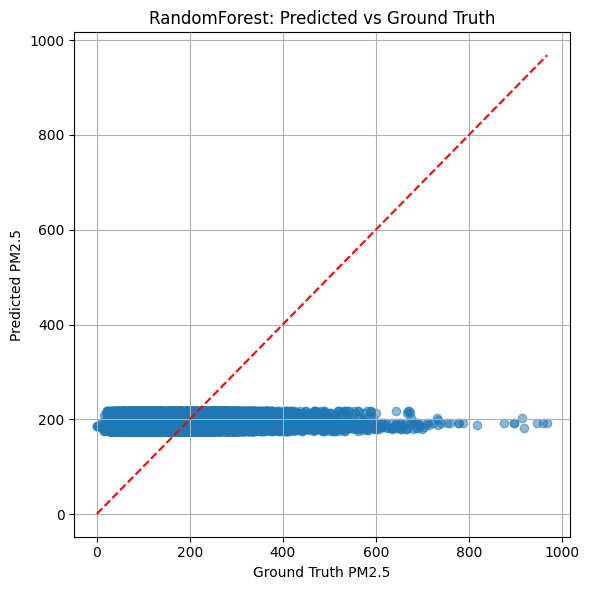

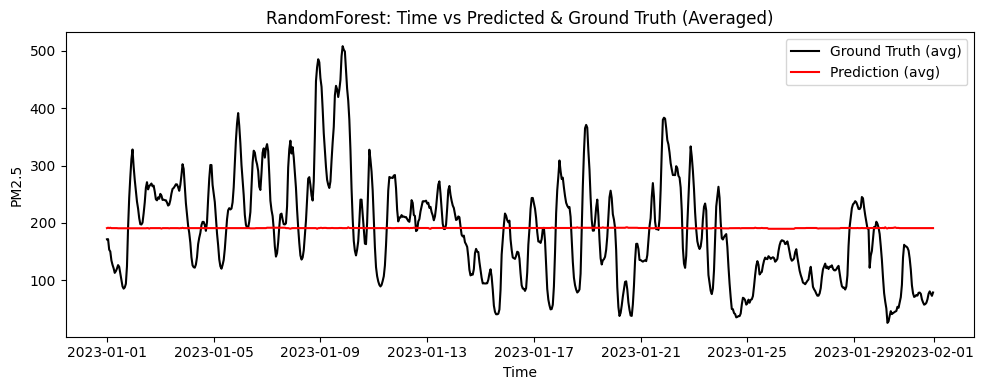

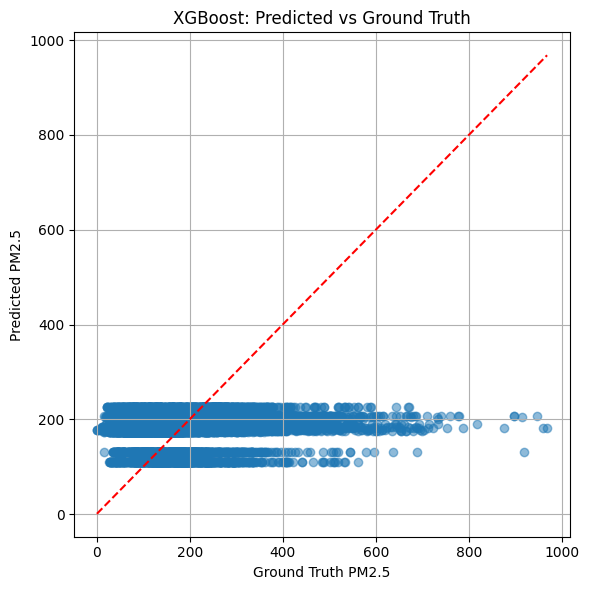

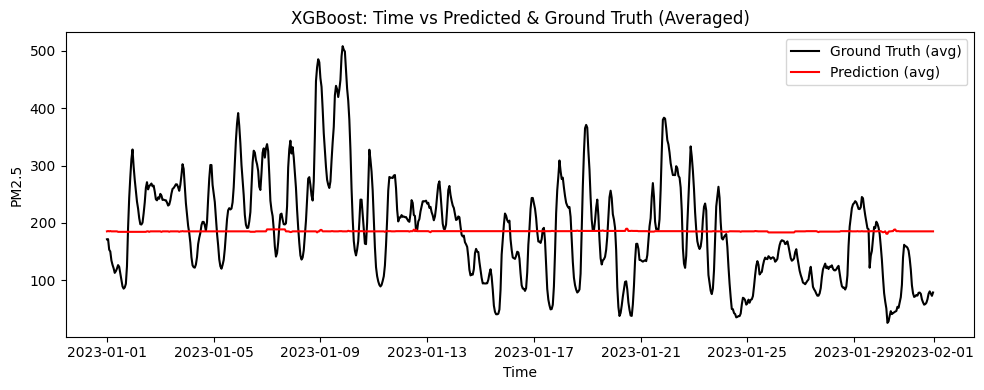

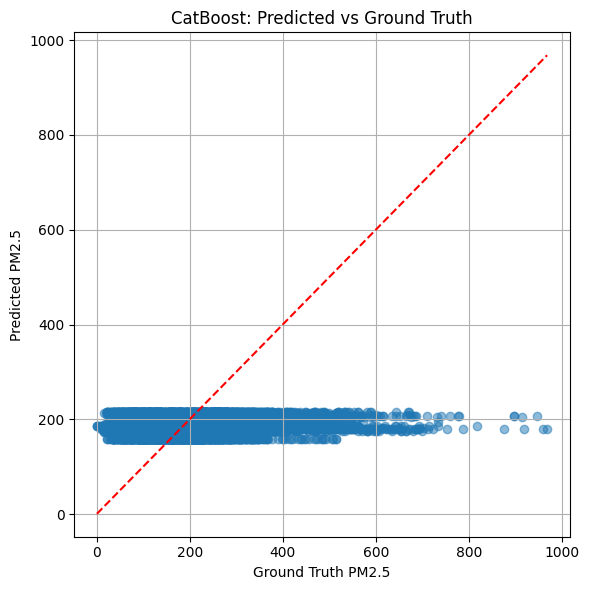

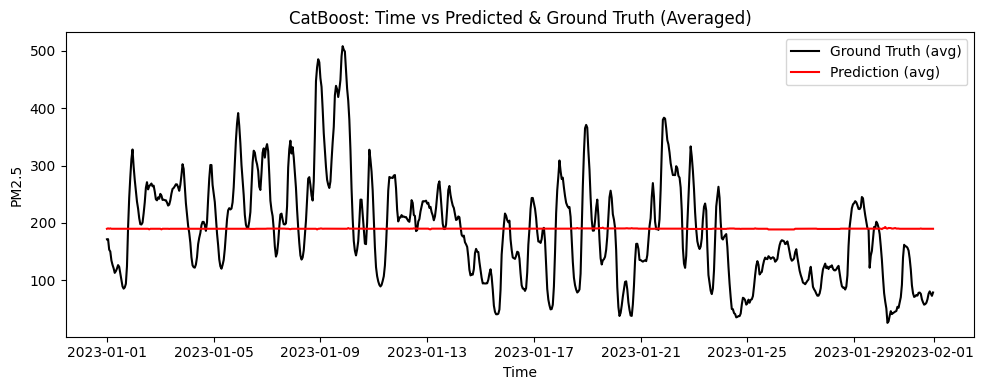

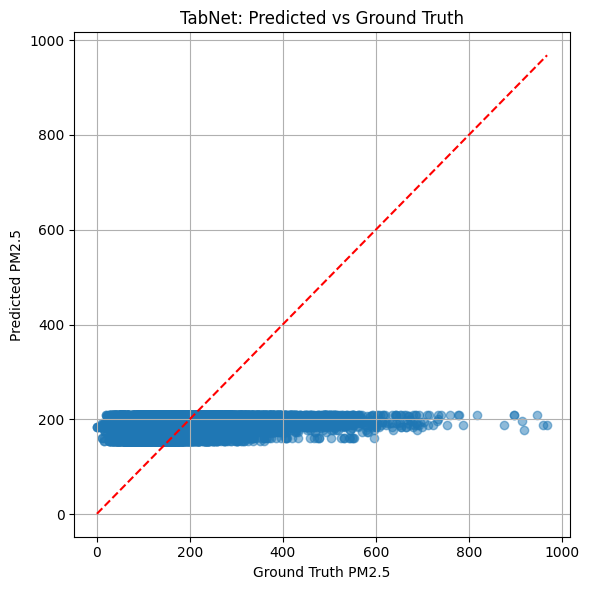

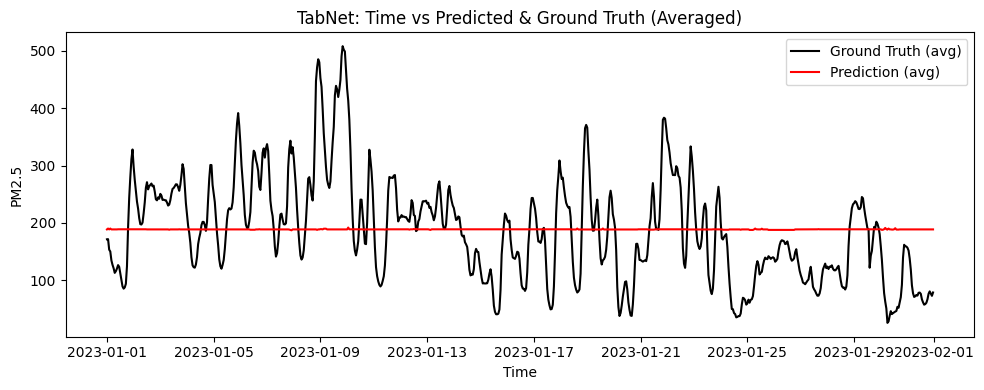

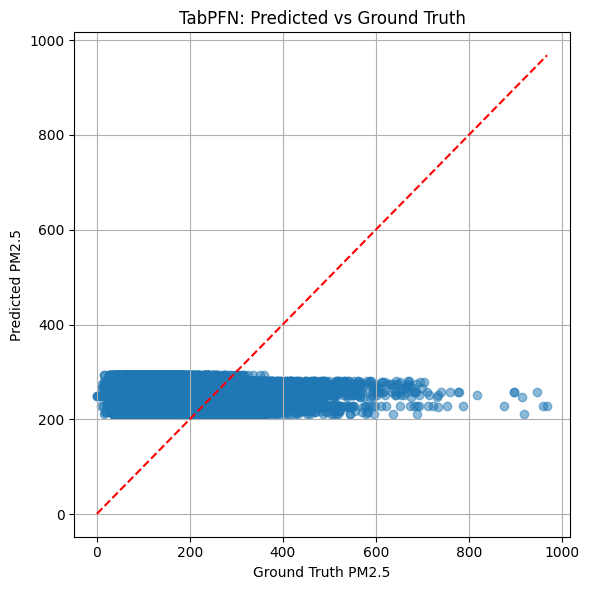

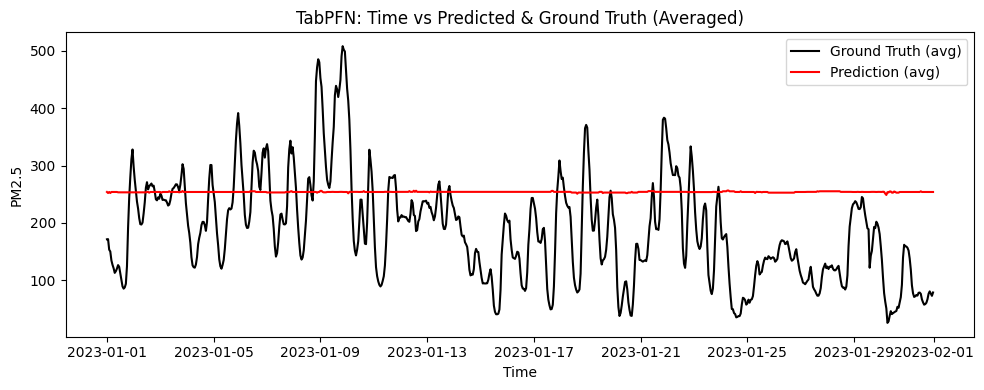

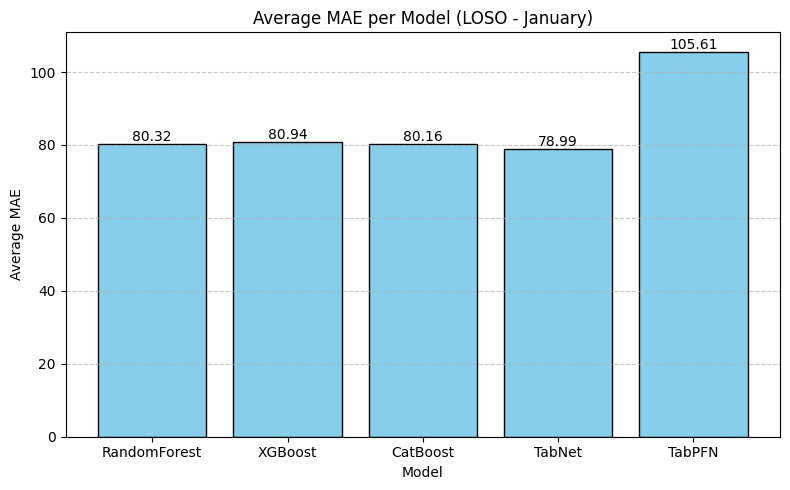

In [ ]:
# --- Metrics Storage ---
results = {
    name: {
        "MAE": [], "RMSE": [], "R2": [],
        "Preds": [], "GT": [], "Time": []
    } for name in models
}

# --- LOSO Loop ---
for station in stations:
    print(f"\n=== Leave-Out Station: {station} ===")
    test_df = df[df['station'] == station]
    train_df = df[df['station'] != station]

    # Drop NA rows
    train_df = train_df.dropna(subset=feature_cols + [target])
    test_df = test_df.dropna(subset=feature_cols + [target])
    if len(train_df) == 0 or len(test_df) == 0:
        print(f"Skipping station {station} due to empty train/test after dropping NA")
        continue

    # Feature Scaling
    X_train_df, X_test_df = safe_standard_scaler(train_df[feature_cols], test_df[feature_cols], feature_cols)
    y_train_vals = train_df[[target]]
    y_test_vals = test_df[[target]]

    # Target scaling
    y_mean = y_train_vals.mean().values[0]
    y_std = y_train_vals.std().values[0]
    if y_std == 0 or np.isnan(y_std):
        y_std = 1.0
    y_train_scaled = (y_train_vals - y_mean) / y_std
    y_test_scaled = (y_test_vals - y_mean) / y_std

    X_train = X_train_df.values
    X_test = X_test_df.values
    y_train = y_train_scaled.values.ravel()
    y_test = y_test_scaled.values.ravel()
    y_train_2d = y_train.reshape(-1, 1)
    y_test_2d = y_test.reshape(-1, 1)

    for name, model in models.items():
        if name == "TabNet":
            model.fit(
                X_train, y_train_2d,
                eval_set=[(X_test, y_test_2d)],
                eval_metric=['rmse'],
                max_epochs=100,
                patience=20,
                batch_size=1024,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False
            )
            y_pred = model.predict(X_test).squeeze()
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Denormalize predictions
        y_pred_denorm = y_pred * y_std + y_mean
        y_test_denorm = y_test * y_std + y_mean

        # Metrics
        mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
        rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
        r2 = r2_score(y_test_denorm, y_pred_denorm)

        results[name]["MAE"].append(mae)
        results[name]["RMSE"].append(rmse)
        results[name]["R2"].append(r2)

        print(f"{name} | MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.2f}")

        # Store predictions and ground truth for plotting
        results[name]["Preds"].extend(y_pred_denorm)
        results[name]["GT"].extend(y_test_denorm)
        results[name]["Time"].extend(test_df['Timestamp'].values)

# --- Summary ---
print("\n\n=== Overall LOSO Results ===")
for name in results:
    mae_mean = np.mean(results[name]["MAE"])
    rmse_mean = np.mean(results[name]["RMSE"])
    r2_mean = np.mean(results[name]["R2"])
    print(f"{name:10s} | MAE: {mae_mean:.2f} | RMSE: {rmse_mean:.2f} | R2: {r2_mean:.2f}")

# --- Plots ---
os.makedirs("loso_plots", exist_ok=True)
for name in results:
    preds = np.array(results[name]["Preds"])
    gt = np.array(results[name]["GT"])
    time = pd.to_datetime(results[name]["Time"])

    # Scatter Plot
    plt.figure(figsize=(6, 6))
    plt.scatter(gt, preds, alpha=0.5)
    plt.plot([gt.min(), gt.max()], [gt.min(), gt.max()], 'r--')
    plt.xlabel("Ground Truth PM2.5")
    plt.ylabel("Predicted PM2.5")
    plt.title(f"{name}: Predicted vs Ground Truth")
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"loso_plots/{name}_scatter.png")
    plt.show()

    # Line Plot over Time (averaged)
    df_plot = pd.DataFrame({
        'time': time,
        'ground_truth': gt,
        'prediction': preds
    })
    df_mean = df_plot.groupby('time').mean().reset_index()

    plt.figure(figsize=(10, 4))
    plt.plot(df_mean['time'], df_mean['ground_truth'], label="Ground Truth (avg)", color='black')
    plt.plot(df_mean['time'], df_mean['prediction'], label="Prediction (avg)", color='red')
    plt.xlabel("Time")
    plt.ylabel("PM2.5")
    plt.title(f"{name}: Time vs Predicted & Ground Truth (Averaged)")
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"loso_plots/{name}_time_avg.png")
    plt.show()

# --- Bar Plot of Average MAE per Model ---
model_names = []
mae_means = []
rmse_mean = []
r2_mean = []

for name in results:
    model_names.append(name)
    mae_means.append(np.mean(results[name]["MAE"]))

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, mae_means, color='skyblue', edgecolor='black')
plt.ylabel("Average MAE")
plt.xlabel("Model")
plt.title("Average MAE per Model (LOSO - January)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f"{height:.2f}", ha='center', va='bottom')

plt.tight_layout()
# plt.savefig("loso_plots/average_mae_barplot.png")
plt.show()